## Replicating the heatmap of datasets and fusion
Comparing the new heatmap of datasets and datasetmeans with the Nettekoven 2024
- Moving the scale out of model improves datasetmeans performance, but decreases most Fusion performances

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
from statannotations.Annotator import Annotator
import Functional_Fusion.dataset as fdata
import glob
import matplotlib.pyplot as plt

In [2]:
def heatmap_annotate(df_to_plot, ds_order, ax, column=['train_dataset'], row=['eval_dataset'], value=['R_eval'], cmap='inferno', vmin=0, vmax=0.5):
    if 'Fusion' in ds_order:
        ds_order_y = [ds for ds in ds_order if ds!='Fusion']
    else:
        ds_order_y = ds_order
    V = pd.pivot_table(df_to_plot, columns=column, index=row, values=value)
    V = V.reindex(ds_order_y, axis=0)
    V = V.reindex(ds_order, level=1, axis=1)

    sns.heatmap(V.values, annot=True, fmt=".2f", cmap=cmap, vmin=vmin, vmax=vmax, 
                xticklabels=V.columns.get_level_values(1).values, 
                yticklabels=V.index.values, square=True, ax=ax)
    if 'Fusion' in ds_order:
        ax.axvline(len(ds_order_y), color='k', linewidth=2)

    return ax

In [2]:
def plot_with_error(df, x_var, y_var, title, error='se'):
    means = df.groupby(x_var)['R_eval'].mean().sort_values(ascending=True)
    ax = sns.barplot(data=df, x=x_var, y=y_var, hue=x_var, errorbar=error, order=means.index.to_list())
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_title(title) 
    return ax, means

### Simple avg across subjects

In [3]:
method = 'L2reg'
# dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
dataset_list = ["MDTB", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
df_all = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = []
    for eval_ds in dataset_list:
        if eval_ds!=dataset_name:
            if eval_ds!='Language':
                eval_data.append(eval_ds)
            else:
                eval_data.append('Languagelocalizer_cond')

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg"],methods=[method],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo"],methods=[method],eval_data=[dataset_name if dataset_name!='Language' else 'Languagelocalizer_cond'],cerebellum='MNISymC3')
    df['model'] = dataset_name+"-loo"
    df_all = pd.concat([df_all, df], ignore_index=True)

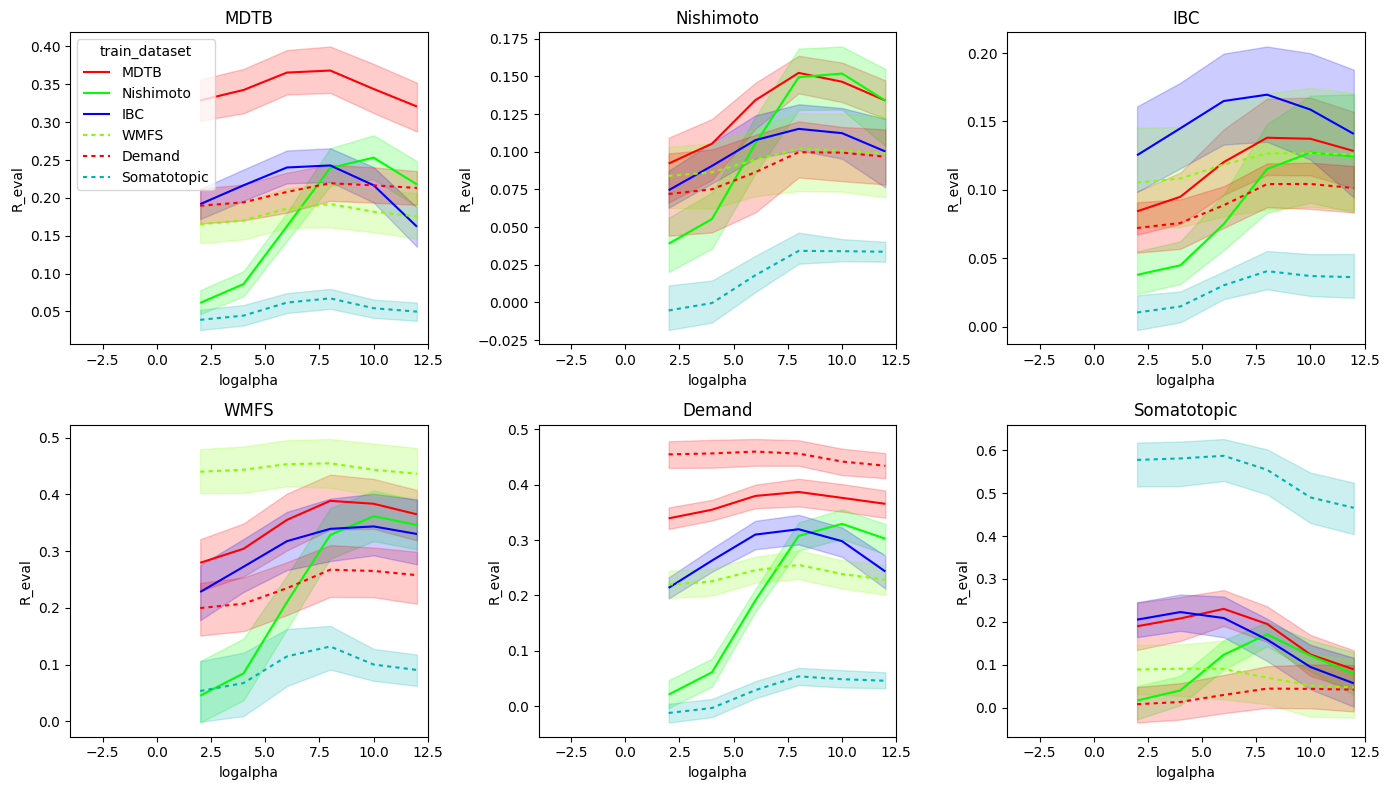

In [15]:
evd=['MDTB','Nishimoto','IBC','WMFS','Demand','Somatotopic']
palette = [[1,0,0],[0,1,0],[0,0,1],[0.5,1,0],[1,0,0],[0,0.7,0.7]]
dashes = [[1,0],[1,0],[1,0],[2,2],[2,2],[2,2]]

plt.figure(figsize=(14,8))
for i,ed in enumerate(evd):
    ax = plt.subplot(2,3,i+1)
    df_to_plot = df_all[(df_all.eval_dataset==ed) & ((df_all.train_dataset!=ed) | (df_all.model.str.contains('loo')))]
    plt.title(ed)
    if i==0:
        sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', palette=palette, style='train_dataset',
                     dashes=dashes, hue_order=evd, style_order=evd)
    else:
        sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', palette=palette, style='train_dataset',
                     dashes=dashes, hue_order=evd, style_order=evd, legend=None)
    plt.xlim([-4, 12.5])
plt.tight_layout()

(-5.0, 13.0)

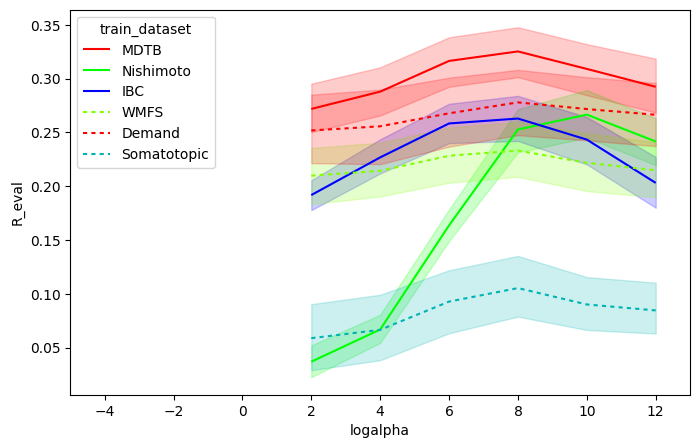

In [5]:
# Plot all evaluations on different datasets
plt.figure(figsize=(8,5))
df_to_plot = df_all[(df_all.train_dataset!=df_all.eval_dataset) | (df_all.model.str.contains('loo'))]
sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha',
             hue='train_dataset', style='train_dataset',
             hue_order=evd, style_order=evd,
             palette=palette, dashes=dashes)
plt.xlim([-5, 13])

In [6]:
ds_order = ["Demand", "IBC", "MDTB", "Nishimoto", "Somatotopic", "WMFS"]
A = pd.pivot_table(df_all,index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(ds_order)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_all['isbest'] = df_all.logalpha.values == bestla.loc[df_all.train_dataset].values.flatten()

R_eval                                                  
logalpha           2.0       4.0       6.0       8.0       10.0      12.0
train_dataset                                                            
Demand         0.251773  0.255634  0.267703  0.277864  0.271662  0.266340
IBC            0.191712  0.226729  0.258283  0.262845  0.243269  0.203015
MDTB           0.271770  0.287838  0.316403  0.325228  0.308976  0.292345
Nishimoto      0.036820  0.066753  0.163505  0.252656  0.266492  0.241513
Somatotopic    0.058691  0.066444  0.092694  0.105258  0.090023  0.084489
WMFS           0.209744  0.214232  0.228241  0.233099  0.221640  0.214800

,best_logalpha
train_dataset,
Demand,8.0
IBC,8.0
MDTB,8.0
Nishimoto,10.0
Somatotopic,8.0
WMFS,8.0


### Summary Graph of all models evaluated at their best hyperparameter. 

In [50]:
# Get cross-validated single training sets models 
d = df_all[((df_all.train_dataset!=df_all.eval_dataset) | (df_all.model.str.contains('loo'))) & df_all.isbest]
# Add the best Fusion model 
dfuse_1 = rm.comb_eval(models=['Fus06-avg'],methods=[method],eval_data=dataset_list,cerebellum='MNISymC3')
dfuse_1.train_dataset = 'Fusion'
d = pd.concat([d,dfuse_1]).reset_index(drop=True)

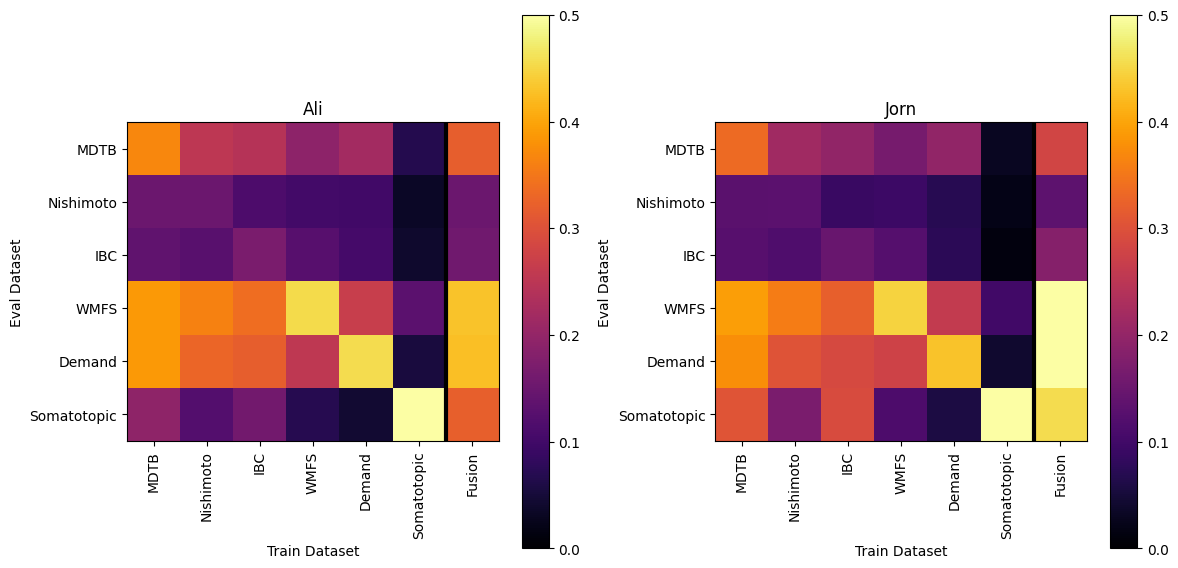

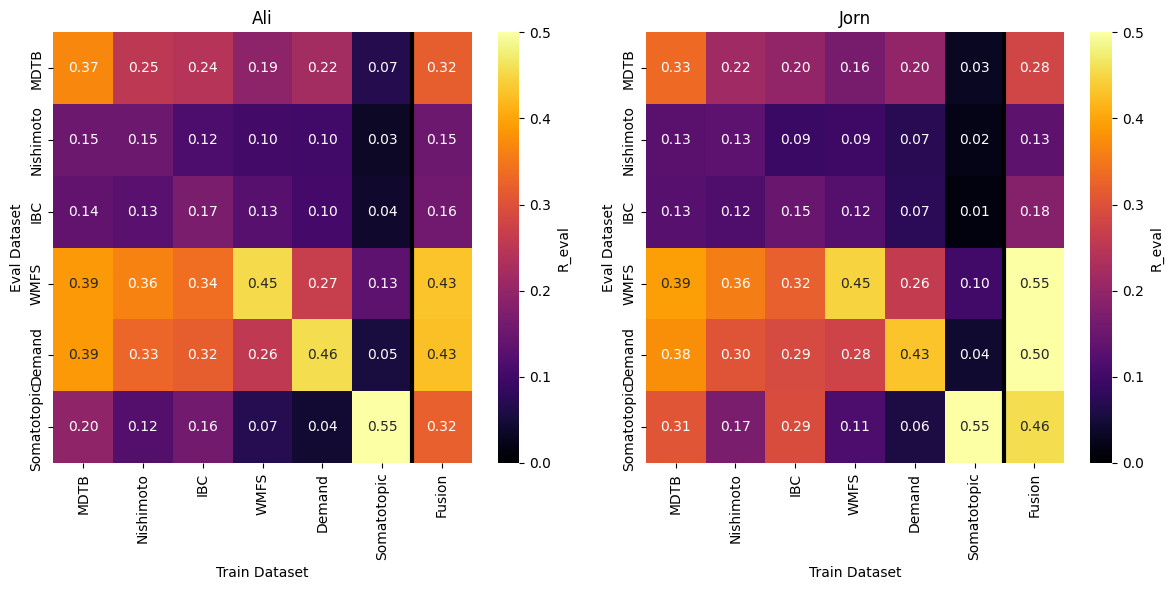

In [ ]:
ds_order = ['MDTB', 'Nishimoto', 'IBC', 'WMFS', 'Demand', 'Somatotopic', 'Fusion']
num_fus_models = 1

d_jorn = pd.read_csv('../data/Nettekoven2024_model_evaluations.tsv',sep='\t')
d_jorn = d_jorn[d_jorn['train_dataset']!='HCP']

fig, axes = plt.subplots(1,2,figsize=(12,6))
for i, df_to_plot in enumerate([d, d_jorn]):
    V = pd.pivot_table(df_to_plot,columns=['train_dataset'],index=['eval_dataset'],values=['R_eval'])
    V = V.reindex(ds_order[:-num_fus_models], axis=0)
    V = V.reindex(ds_order, level=1, axis=1)

    
    plt.subplot(1,2,i+1)
    plt.imshow(V.values, cmap='inferno', vmin=0, vmax=0.5)
    plt.xticks(np.arange(len(ds_order)),V.columns.values)
    axes[i].set_xticklabels(V.columns.get_level_values(1).values, rotation=90)
    plt.yticks(np.arange(len(ds_order)-num_fus_models),V.index.values)
    plt.axvline(5.5, color='k', linewidth=3)
    plt.colorbar()

    if i==0:
        plt.title('Ali')
    else:
        plt.title('Jorn')
    plt.xlabel('Train Dataset')
    plt.ylabel('Eval Dataset')
plt.tight_layout()

fig, axes = plt.subplots(1,2,figsize=(12,6))
for i, df_to_plot in enumerate([d, d_jorn]):
    V = pd.pivot_table(df_to_plot,columns=['train_dataset'],index=['eval_dataset'],values=['R_eval'])
    V = V.reindex(ds_order[:-num_fus_models], axis=0)
    V = V.reindex(ds_order, level=1, axis=1)

    
    plt.subplot(1,2,i+1)
    sns.heatmap(V.values, annot=True, fmt=".2f", cmap='inferno', vmin=0, vmax=0.5, 
                xticklabels=V.columns.get_level_values(1).values, 
                yticklabels=V.index.values, cbar_kws={'label': 'R_eval'})
    plt.axvline(6, color='k', linewidth=3)

    if i==0:
        plt.title('Ali')
    else:
        plt.title('Jorn')
    plt.xlabel('Train Dataset')
    plt.ylabel('Eval Dataset')
plt.tight_layout()

In [56]:
# Get cross-validated single training sets models 
d = df_all[((df_all.train_dataset!=df_all.eval_dataset) | (df_all.model.str.contains('loo'))) & df_all.isbest]
# Add the best Fusion model 
dfuse_1 = rm.comb_eval(models=['Fus06-avg'],methods=[method],eval_data=dataset_list,cerebellum='MNISymC3')
dfuse_1.train_dataset = 'Fusion'
dfuse_2 = rm.comb_eval(models=['Fus06-weighted-avg'],methods=[method],eval_data=dataset_list,cerebellum='MNISymC3')
dfuse_2.train_dataset = 'Weighted Fusion'
dfuse_3 = rm.comb_eval(models=['Fus06-weighted-nonnorm-avg'],methods=[method],eval_data=dataset_list,cerebellum='MNISymC3')
dfuse_3.train_dataset = 'NonNorm Weighted Fusion'
d = pd.concat([d,dfuse_1,dfuse_2,dfuse_3]).reset_index(drop=True)

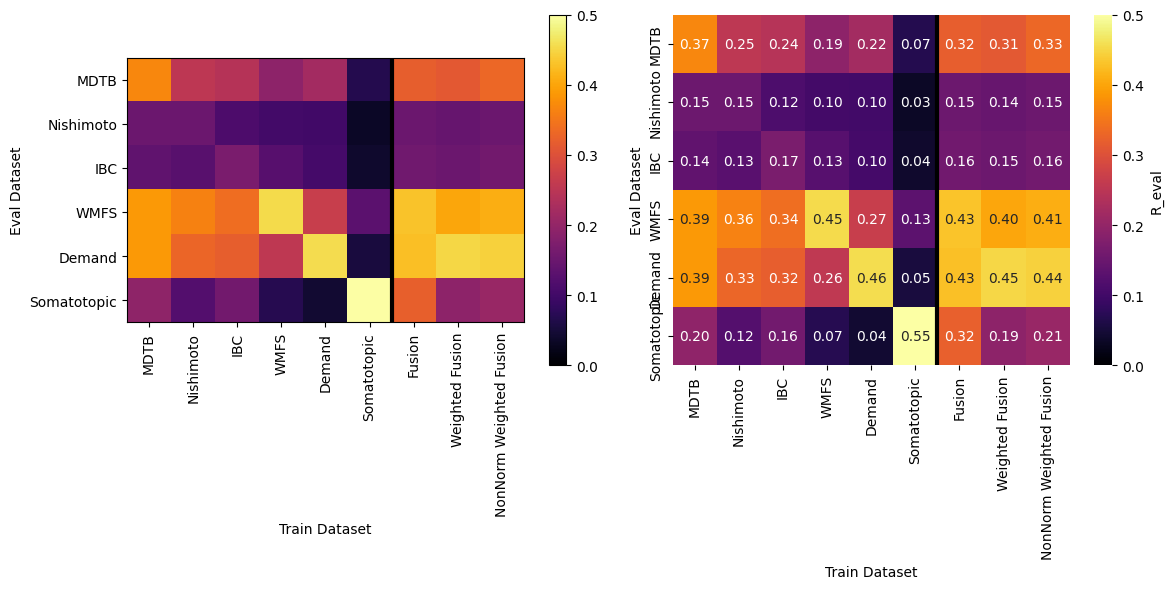

In [58]:
ds_order = ['MDTB', 'Nishimoto', 'IBC', 'WMFS', 'Demand', 'Somatotopic', 'Fusion', 'Weighted Fusion', 'NonNorm Weighted Fusion']
num_fus_models = 3

fig, axes = plt.subplots(1,2,figsize=(12,6))
for i in range(2):
    V = pd.pivot_table(d,columns=['train_dataset'],index=['eval_dataset'],values=['R_eval'])
    V = V.reindex(ds_order[:-num_fus_models], axis=0)
    V = V.reindex(ds_order, level=1, axis=1)

    
    plt.subplot(1,2,i+1)
    if i==0:
        plt.imshow(V.values, cmap='inferno', vmin=0, vmax=0.5)
        plt.xticks(np.arange(len(ds_order)),V.columns.values)
        axes[i].set_xticklabels(V.columns.get_level_values(1).values, rotation=90)
        plt.yticks(np.arange(len(ds_order)-num_fus_models),V.index.values)
        plt.axvline(5.5, color='k', linewidth=3)
        plt.colorbar()
    else:
        sns.heatmap(V.values, annot=True, fmt=".2f", cmap='inferno', vmin=0, vmax=0.5, 
                    xticklabels=V.columns.get_level_values(1).values, 
                    yticklabels=V.index.values, cbar_kws={'label': 'R_eval'})
        plt.axvline(6, color='k', linewidth=3)
    
    plt.xlabel('Train Dataset')
    plt.ylabel('Eval Dataset')
plt.tight_layout()

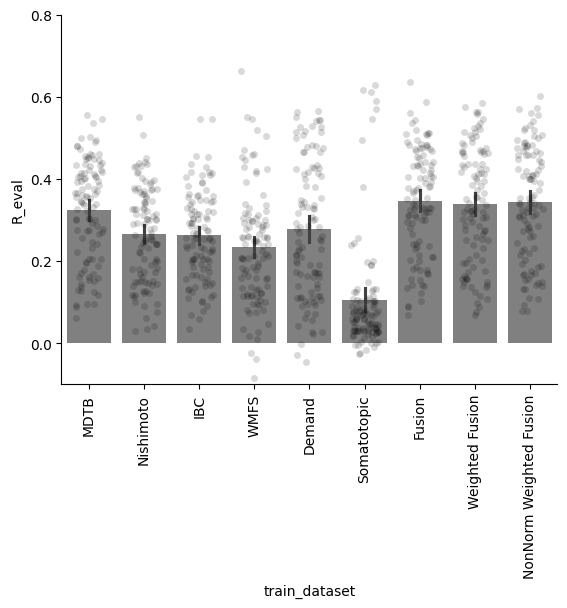

In [59]:
sns.barplot(data=d,x='train_dataset',y='R_eval',order=ds_order,color=[0.5,0.5,0.5])
sns.stripplot(data=d,x='train_dataset',y='R_eval',color=[0,0,0], alpha=0.15,jitter=0.25)
ax=plt.gca()
ax.set_xticks(np.arange(len(ds_order)))
a=ax.set_xticklabels(ds_order, rotation=90)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([-0.1, 0.8])
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])

## Replication of Nettekoven 2024

This section implements the replication of Nettekoven 2024 using the same exact models and code as described in the original study.


In [3]:
d_jorn = pd.read_csv('../data/Nettekoven2024_model_evaluations.tsv',sep='\t')
d_jorn = d_jorn[d_jorn['train_dataset']=='Fusion']
d_replication = rm.comb_eval(models=['Fu06-loo-replication'])
d_replication['train_dataset'] = 'Fusion'
d_suit3 = rm.comb_eval(models=['Fus06-bestSTD-avg'],methods=['L2reg'])
d_suit3['train_dataset'] = 'Fusion'

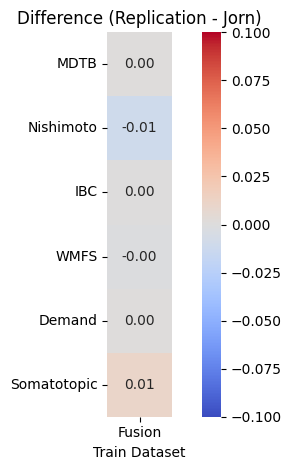

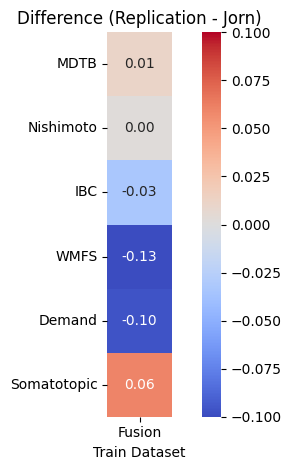

In [5]:
ds_order = ['MDTB', 'Nishimoto', 'IBC', 'WMFS', 'Demand', 'Somatotopic', 'Fusion']

# Calculate the difference in 'R_eval' for the same group of (train_dataset, eval_dataset, eval_subj)
df_diff = pd.merge(d_replication[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   d_jorn[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   on=['train_dataset', 'eval_dataset', 'eval_subj'],
                   suffixes=('_replication', '_Jorn'))

df_diff['R_eval_diff'] = df_diff['R_eval_replication'] - df_diff['R_eval_Jorn']
ax = heatmap_annotate(df_diff, ds_order, ax=plt.gca(), value=['R_eval_diff'], cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax.set_title('Difference (Replication - Jorn)')
ax.set_xlabel('Train Dataset')

plt.tight_layout()

plt.figure()
# Calculate the difference in 'R_eval' for the same group of (train_dataset, eval_dataset, eval_subj)
df_diff = pd.merge(d_suit3[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   d_jorn[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   on=['train_dataset', 'eval_dataset', 'eval_subj'],
                   suffixes=('_replication', '_Jorn'))

df_diff['R_eval_diff'] = df_diff['R_eval_replication'] - df_diff['R_eval_Jorn']
ax = heatmap_annotate(df_diff, ds_order, ax=plt.gca(), value=['R_eval_diff'], cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax.set_title('Difference (Replication - Jorn)')
ax.set_xlabel('Train Dataset')

plt.tight_layout()